In [1]:
# attempt to predict gender by essay topics

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


# set max colwidth to -1 because leaving the defaults messes 
# with the charcount when joining the essays
pd.set_option('display.max_colwidth', -1)

df = pd.read_csv('profiles.csv')

# get the essays by gender
def get_essays(gender):
    return df[df.sex == gender][['essay0', 'essay1', 'essay2', 'essay3',
        'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]

male_essays = get_essays('m')
female_essays = get_essays('f')
print(len(male_essays))
print(len(female_essays))

35829
24117


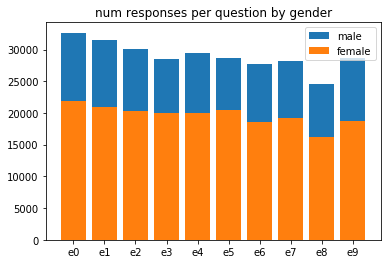

[32648, 31434, 30069, 28467, 29403, 28669, 27652, 28236, 24541, 28614]


In [3]:
#plot a stacked bar chart of numbers of answers to each question by gender
def get_total_answers(column):
    return len(column.dropna())

male_answers = male_essays.apply(get_total_answers, axis=0)
female_answers = female_essays.apply(get_total_answers, axis=0)

titles = ['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9']
male_bar = plt.bar(titles, male_answers.tolist())
female_bar = plt.bar(titles, female_answers.tolist())

plt.title('num responses per question by gender')
plt.legend((male_bar[0], female_bar[0]), ('male', 'female'))
plt.show()

print(male_answers.tolist())

# NB Classification

In [4]:
# drop any rows that are NaN
male_essay3 = male_essays.essay3.dropna()
female_essay3 = female_essays.essay3.dropna()
print('male len: ', len(male_essay3))
print('female len: ', len(female_essay3))

male len:  28467
female len:  20003


In [5]:
# replace \n and <br /> with space, make responses a list
male_essay3_text = male_essay3.apply(lambda x: x.replace('\n', ' ').replace('<br />', ' ')).tolist()
female_essay3_text = female_essay3.apply(lambda x: x.replace('\n', ' ').replace('<br />', ' ')).tolist()

all_essay3 = male_essay3_text + female_essay3_text
labels = [0] * len(male_essay3_text) + [1] * len(female_essay3_text)

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(all_essay3, labels, test_size = 0.2, random_state = 1)
print(len(train_data))
print(len(test_data))

38776
9694


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer()
counter.fit(train_data)
train_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)

In [8]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(train_counts, train_labels)
predictions = classifier.predict(test_counts)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# save confusion matrix and slice into four pieces
confusion = confusion_matrix(test_labels, predictions)
print("confusion matrix: ")
print(confusion)

# accuracy
print('accuracy: %f' % (accuracy_score(test_labels, predictions)))

# precision
print('precision: %f' % (precision_score(test_labels, predictions)))

# recall
print('recall: %f' % (recall_score(test_labels, predictions)))

confusion matrix: 
[[4017 1702]
 [1641 2334]]
accuracy: 0.655148
precision: 0.578295
recall: 0.587170


In [ ]:
# 👎🏿 Multinomial Naive Bayes is a loser.

# KNN Classification

In [10]:
import collections

def get_word_frequency(essay_list):
    essay_as_list = []
    for essay in essay_list:
        essay_as_list.append(essay.replace('\n', ' ').replace('<br />', ' ').split())

    essay_words = [word for essay in essay_as_list for word in essay]
    essay_words_freq = collections.Counter(essay_words)

    essay_word_df = pd.DataFrame.from_dict(essay_words_freq, orient='index').reset_index()
    essay_word_df = essay_word_df.rename(columns={'index':'word', 0:'count'})
    essay_word_df.sort_values('count', ascending=False, inplace=True)
    return essay_word_df

male_word_freq = get_word_frequency(male_essay3_text)
female_word_freq = get_word_frequency(female_essay3_text)

# get top 100 words for both sets of essays
top_male_words = male_word_freq[0:100]['word'].tolist()
top_female_words = female_word_freq[0:100]['word'].tolist()

# pluck out the 100 unique ones between the lists
top_words = []
[top_words.append(x) for x in (top_male_words + top_female_words) if x not in top_words]
top_words = top_words[0:100]

In [11]:
# drop NaN rows and replace any \n and <br /> with a space
essay3_word_counts = df[['essay3', 'sex']].dropna()
essay3_word_counts.essay3 = essay3_word_counts.essay3.apply(lambda x: x.replace('\n', ' '))
essay3_word_counts.essay3 = essay3_word_counts.essay3.apply(lambda x: x.replace('<br />', ' '))

# create a new column in the essay3_word_counts dataframe
for word in top_words:
    essay3_word_counts[word+'_count'] = essay3_word_counts.essay3.apply(lambda x: x.split().count(word))


In [12]:
#create a list of labels
essay3_labels = essay3_word_counts.sex.apply(lambda x: 0 if x == 'm' else 1).tolist()

# create the wordcount dataset
essay3_top_words_dataset = essay3_word_counts.drop(['essay3', 'sex'], axis=1)
essay3_top_words_dataset = essay3_top_words_dataset.values.tolist()


In [13]:
from sklearn.neighbors import KNeighborsClassifier

training_data, validation_data, training_labels, validation_labels = train_test_split(essay3_top_words_dataset, essay3_labels, test_size = 0.2, random_state = 99)
k_list = range(1, 101)
accuracies = []
for k in range(1, 101):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(training_data, training_labels)
    score = classifier.score(validation_data, validation_labels)
    print('k: %d, score: %f' % (k, score))
    accuracies.append(score)
  
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('validation accuracy')
plt.title('essay3 top word classifier accuracy')
plt.show()

k: 100, score: 0.603157
k: 200, score: 0.605529
k: 300, score: 0.610171
k: 400, score: 0.608933
k: 500, score: 0.607902
k: 600, score: 0.601300
k: 700, score: 0.599546
k: 800, score: 0.598411
k: 900, score: 0.599959
k: 1000, score: 0.599959


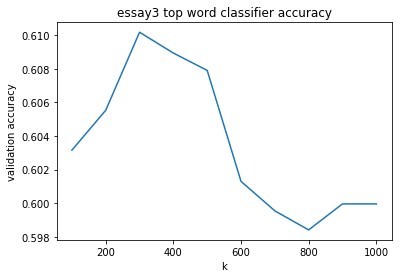

In [240]:
k_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
accuracies = []
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(training_data, training_labels)
    score = classifier.score(validation_data, validation_labels)
    print('k: %d, score: %f' % (k, score))
    accuracies.append(score)

plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('validation accuracy')
plt.title('essay3 top word classifier accuracy')
plt.show()

k: 1000, score: 0.599959
k: 2000, score: 0.589849
k: 3000, score: 0.589230
k: 4000, score: 0.589230
k: 5000, score: 0.588508
k: 6000, score: 0.584795
k: 7000, score: 0.583969
k: 8000, score: 0.582525
k: 9000, score: 0.582422
k: 10000, score: 0.582216


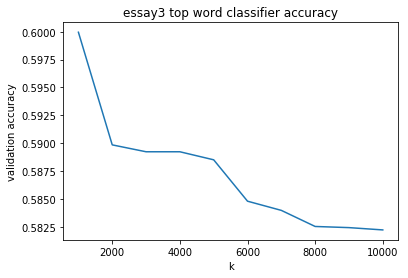

In [241]:
k_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
accuracies = []
for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(training_data, training_labels)
    score = classifier.score(validation_data, validation_labels)
    print('k: %d, score: %f' % (k, score))
    accuracies.append(score)

plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('validation accuracy')
plt.title('essay3 top word classifier accuracy')
plt.show()

In [14]:
# create a classifier with the K that yeilded the highest accuracy (300)
classifier = KNeighborsClassifier(n_neighbors=300)
classifier.fit(training_data, training_labels)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=300, p=2,
           weights='uniform')

In [15]:
# get accuracy
classifier.score(validation_data, validation_labels)

0.6101712399422323

In [16]:
# print confusion matrix
predictions = classifier.predict(validation_data)

In [17]:
confusion_matrix(validation_labels, predictions)

array([[5127,  516],
       [3263,  788]])

In [18]:
from sklearn.metrics import classification_report
print(classification_report(validation_labels, predictions))

             precision    recall  f1-score   support

          0       0.61      0.91      0.73      5643
          1       0.60      0.19      0.29      4051

avg / total       0.61      0.61      0.55      9694



In [ ]:
# 👎🏿 KNN is another flop.

# KNN Regressor

In [20]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors = 300, weights = 'distance')
regressor.fit(training_data, training_labels)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=300, p=2,
          weights='distance')

In [23]:
# get accuracy
print(regressor.score(validation_data, validation_labels))


-0.019285010143822667


In [ ]:
# SVM 

In [ ]:
# use KNN data with a support vector machine
from sklearn.svm import SVC

svm_classifier = SVC(kernel = 'linear')
svm_classifier.fit(training_data, train_labels)

# get accuracy
print(classifier.score(validation_data, validation_labels))

predictions = classifier.predict(validation_data)
print(confusion_matrix(validation_labels, predictions))
print(classification_report(validation_labels, predictions))